# Notebook 3:  Data Modeling

In this notebook, we utilize data from two previous notebooks to develop and train a model that predicts player market values. Additional features are created, and we categorize players into 7 salary classes, which will serve as the target variable for our machine learning model. We analyze feature-target relationships through plots and employ algorithms and iterative techniques to identify the most relevant features. After thorough refinement, we end up with a final set of 8 features. The model training phase begins, incorporating a validation set for hyperparameter tuning. Eventually, a separate testing set is employed to evaluate the model's overall performance.

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif

# Feature Handling (7 Classes for Random Forest)

In [4]:
df = pd.read_csv('./data/cleaned_pastyears.csv')
df2022 = pd.read_csv('./data/cleaned_currentyear.csv')

# Fill NAs

df['FG%_'] = df['FG%'].fillna(df['FG%'].median())  
df['FT%_'] = df['FT%'].fillna(df['FT%'].median())  
df['TS%_'] = df['TS%'].fillna(df['TS%'].median())  
df['3P%_'] = df['3P%'].fillna(df['3P%'].median())                 
df2022['FG%_'] = df['FG%'].fillna(df['FG%'].median())  
df2022['FT%_'] = df['FT%'].fillna(df['FT%'].median())  
df2022['TS%_'] = df['TS%'].fillna(df['TS%'].median())  
df2022['3P%_'] = df['3P%'].fillna(df['3P%'].median())  

# Feature Engineering and Cleanup

totalgames = {2016: 82,    2017: 82,    2018: 82,   2019: 75,   
             2020: 72,    2021: 82,    2022: 82,    2023: 82}

for index, row in df.iterrows():    
    G =  df.loc[index, 'G']
    GS =  df.loc[index, 'GS']
    prevyear = df.loc[index, 'PrevYear']
    GTOT = totalgames[prevyear]
    G_pct = G/GTOT
    df.loc[index, 'G_pct'] = G_pct
    GS_pct = GS/GTOT
    df.loc[index, 'GS_pct'] = GS_pct

for index, row in df2022.iterrows():
    G =  df2022.loc[index, 'G']
    GS =  df2022.loc[index, 'GS']
    GTOT = 82
    G_pct = G/GTOT
    GS_pct = GS/GTOT
    df2022.loc[index, 'G_pct'] = G_pct
    df2022.loc[index, 'GS_pct'] = GS_pct
    
df['GS/G'] = df['GS']/df['G']
df2022['GS/G'] = df2022['GS']/df2022['G']

def heightinfeet(height):
    try:
        height_ft  = float(height.split('-')[0]) + float(height.split('-')[1])/12
        return height_ft
    except:
        return np.nan
    
df['Height_ft'] = df['Height'].apply(heightinfeet)

# Bucket Salaries

def sal_bucket(salary):
    if  pd.isnull(salary):
        return 'N/A'
    elif salary < 5: 
        return 0
    elif salary < 10:
        return 5
    elif salary < 15:
        return 10
    elif salary < 20:
        return 15
    elif salary < 25:
        return 20
    elif salary < 30:
        return 25
    elif salary < 50:
        return 30
    
df['Sal_class'] = df['NextSalNorm'].apply(sal_bucket)
df2022['Sal_class'] = df2022['SalClean'].apply(sal_bucket)

# Features

allfeats = ['Height_ft','Age', 'G_pct', 'GS_pct','GS/G','MP', 'PTS',
            'TS%_','3P', '3PA', '3P%_', 'FT','FTA', 'FT%_', 'USG%',
            'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
            'PER', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM','VORP']

# Train/Test and Testing set

df_model = df[(df.PrevYear != 2021)]
df_holdout = df[(df.PrevYear == 2021)]

# Plot salary class frequency

classes = df_model['Sal_class'].value_counts().sort_index().index.tolist()
classes = [value+2.5 for value in classes]
counts = df_model['Sal_class'].value_counts().sort_index().tolist()

plt.figure(figsize=(8, 6))
plt.bar(classes, counts, width=4.8)

print(df_model['Sal_class'].value_counts().sort_index())

KeyError: 'SalClean'

# Feature Selection

### Feature-Target Plots

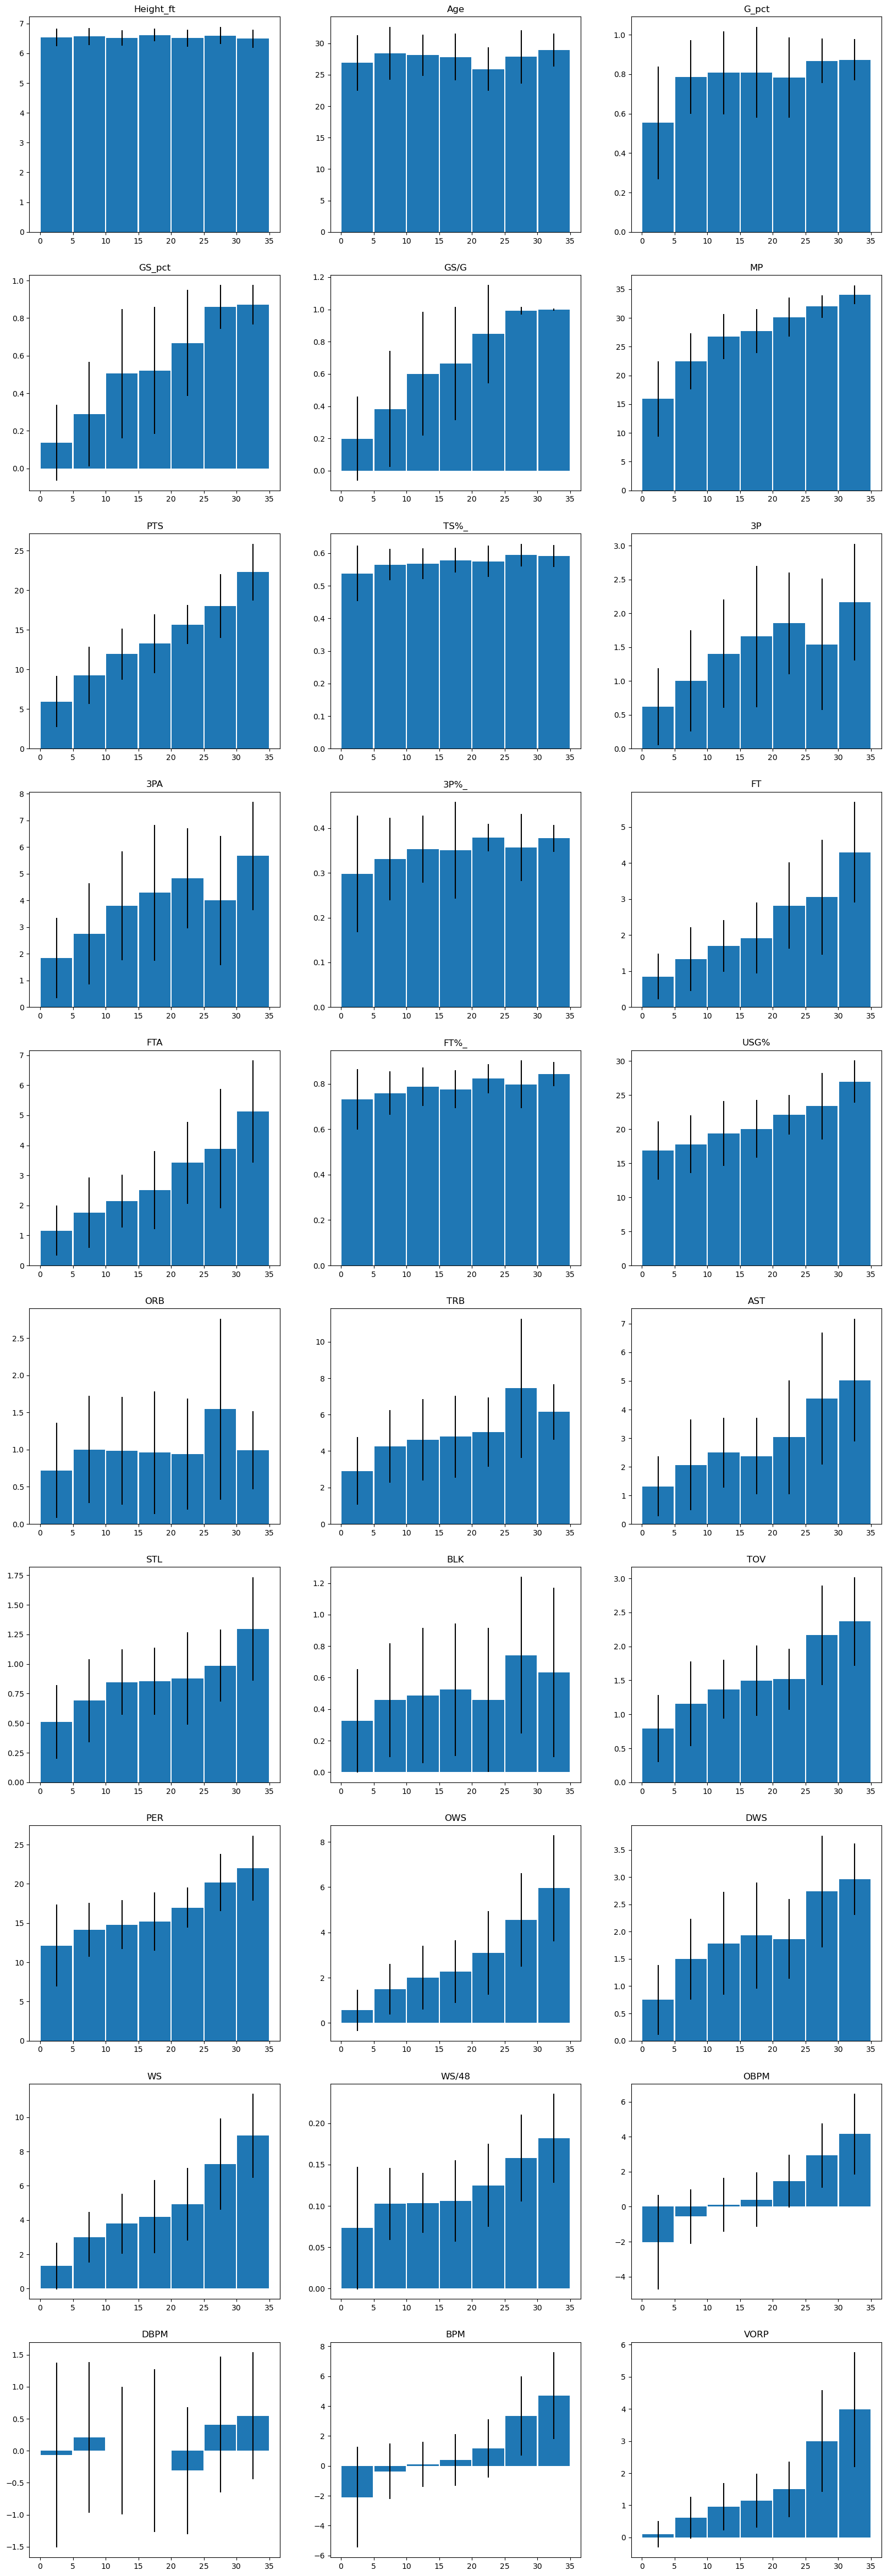

In [3]:
df_buckets = df.groupby('Sal_class')[allfeats].mean()
df_buckets.reset_index(inplace=True)
df_buckets_std = df.groupby('Sal_class')[allfeats].std()
df_buckets_std.reset_index(inplace=True)

fig, ax = plt.subplots(10,3, figsize = (20, 60))
ax = ax.flatten()
for idx, col in enumerate(allfeats, 0):
    ax[idx].bar(2.5+df_buckets['Sal_class'], df_buckets[col], yerr = df_buckets_std[col], width=4.8)
    ax[idx].set_title(col)

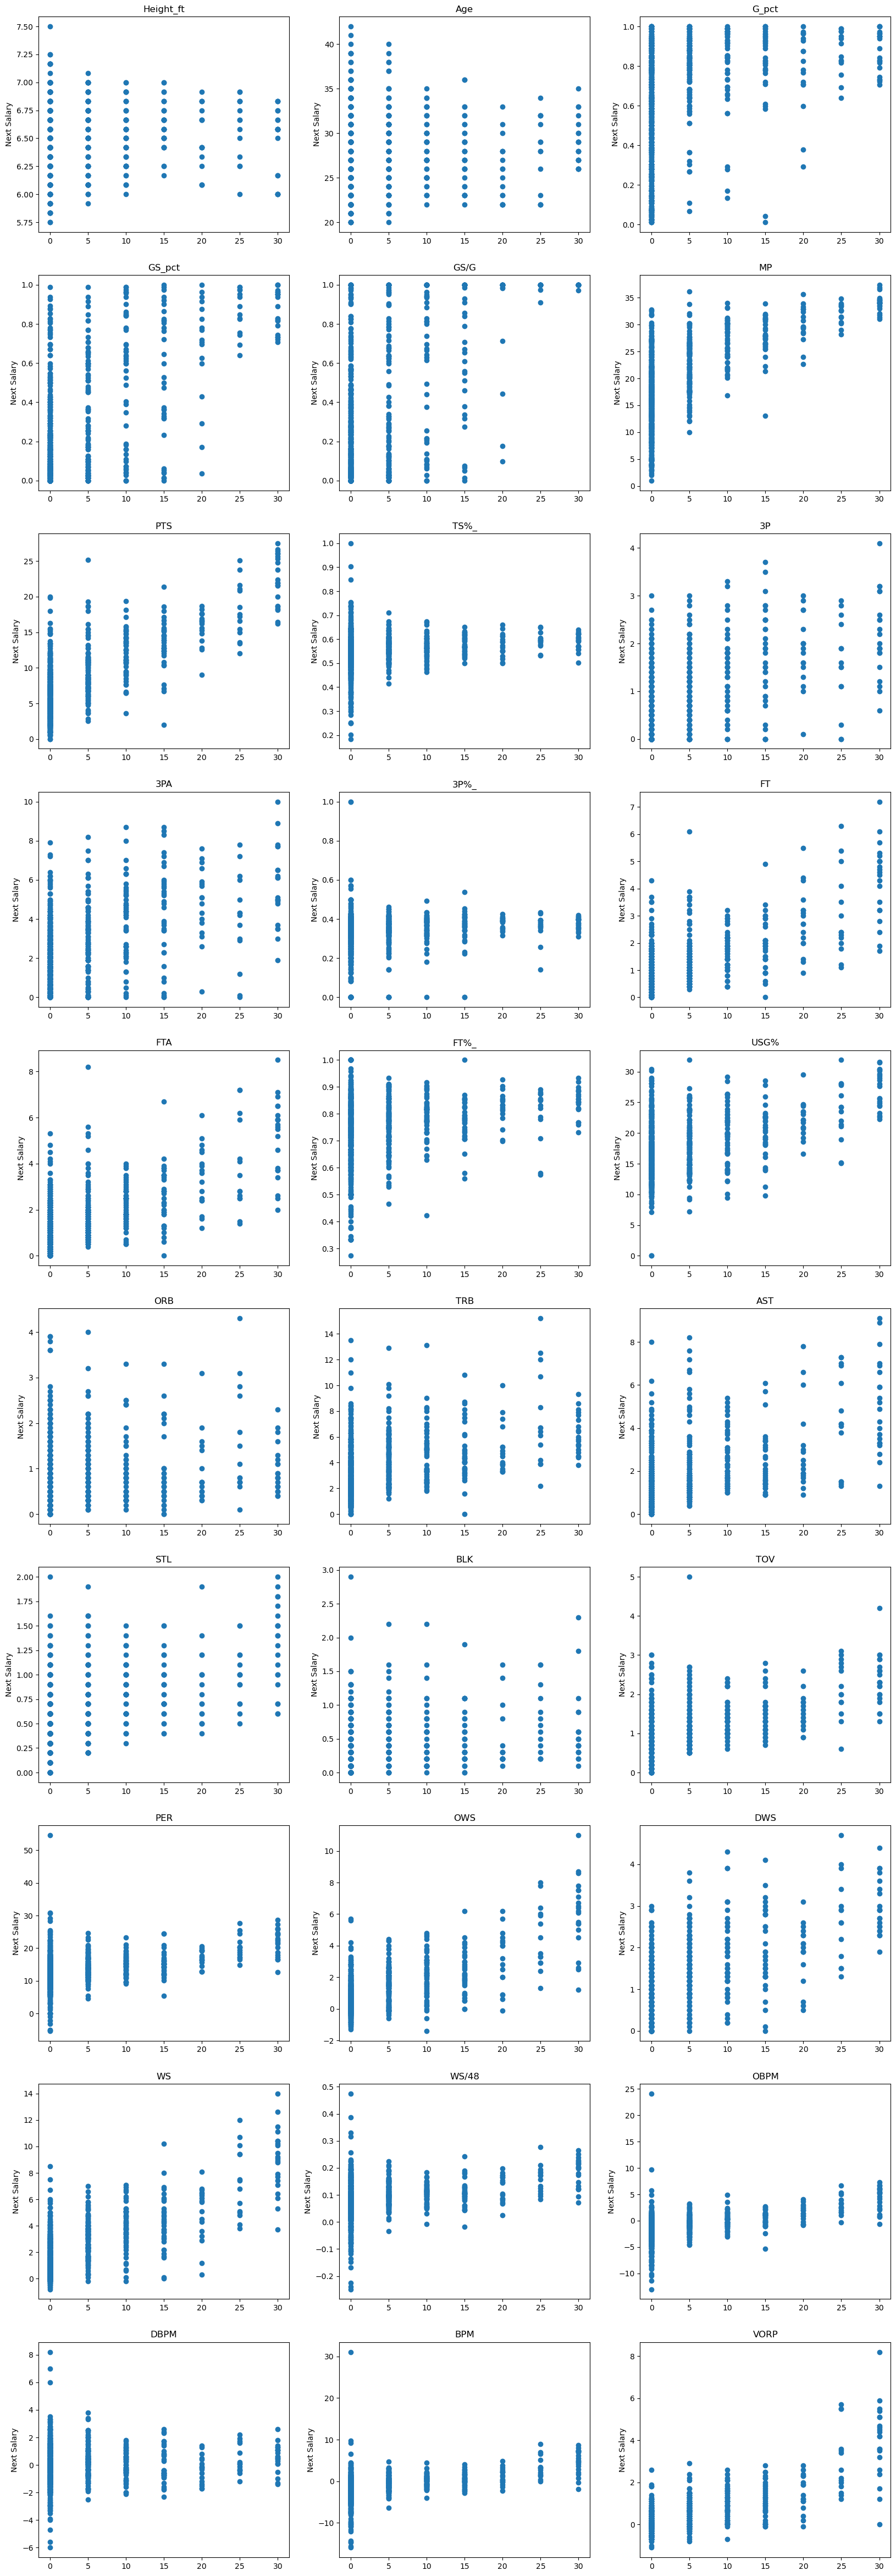

In [4]:
df_buckets = df.groupby('Sal_class')[allfeats].mean()
df_buckets.reset_index(inplace=True)
df_buckets_std = df.groupby('Sal_class')[allfeats].std()
df_buckets_std.reset_index(inplace=True)

fig, ax = plt.subplots(10,3, figsize = (20, 60))
ax = ax.flatten()
for idx, col in enumerate(allfeats, 0):
    ax[idx].plot(df['Sal_class'],df[col] , 'o')
    ax[idx].set_ylabel('Next Salary')
    ax[idx].set_title(col)

### Feature Selection Algorithms

Features ranked by RFE (descending):
['VORP', 'OBPM', 'FT', 'PER', 'OWS', 'FTA', 'GS_pct', 'USG%', 'DWS', 'BPM'] 

Selected best 10:
['GS_pct', 'GS/G', 'MP', 'PTS', 'FT', 'FTA', 'OWS', 'DWS', 'WS', 'VORP'] 

Features ranked by information gain (descending):
['MP', 'PTS', 'VORP', 'WS', 'DWS', 'FT', 'OWS', 'OBPM', 'GS/G', 'TOV'] 



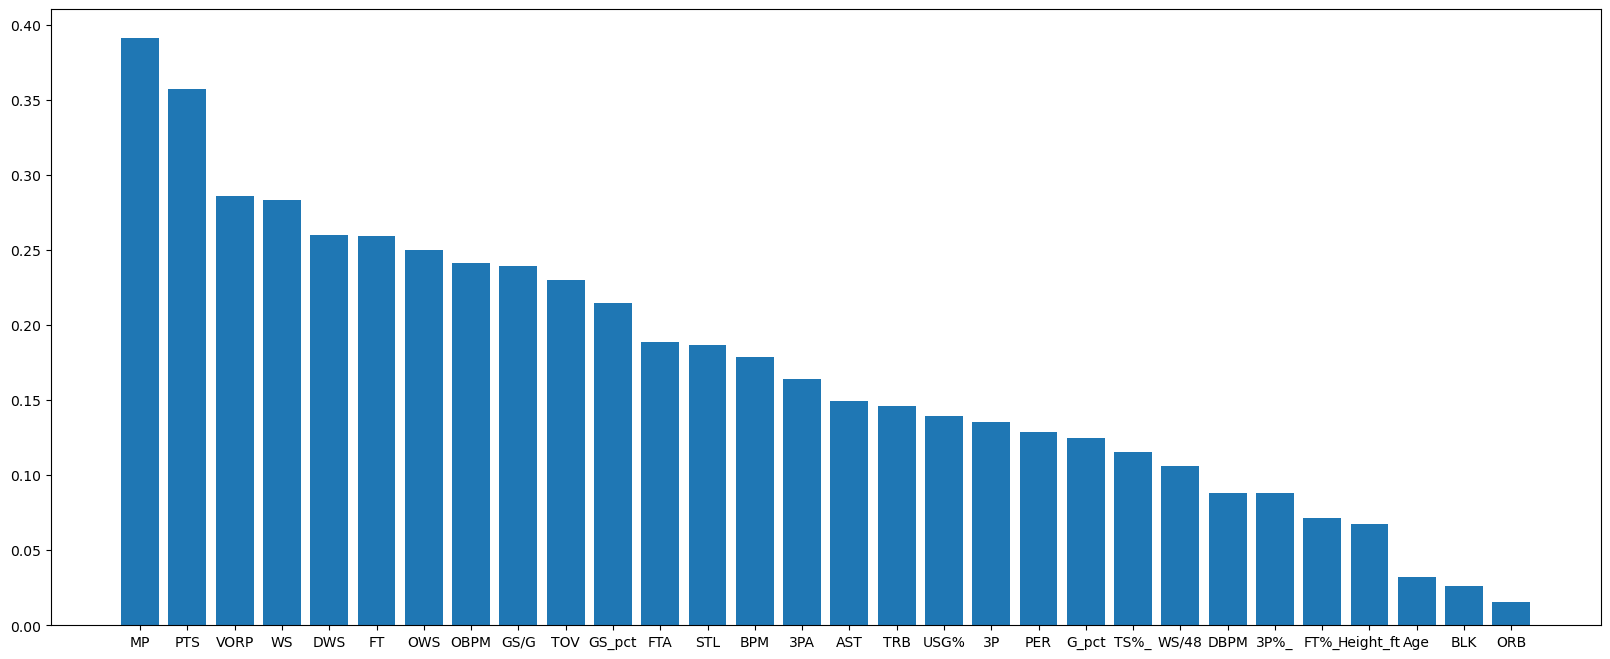

In [5]:
#SelectKBest

def selectkbest_rankings(X_train, y_train):

    select = SelectKBest(k=10)
    z = select.fit_transform(X_train,y_train)

    k_filter = select.get_support()
    k_filter_feats = [feats[i] for i in range(len(feats)) if k_filter[i]]
 
    print("Selected best 10:")
    print(k_filter_feats, '\n')

#Mutual Information Gain

def mutualinfo_rankings(X_train, y_train):

    importances = mutual_info_classif(X_train, y_train)
    df_test = pd.DataFrame({"features": feats, "importances": importances})
    df_sorted = df_test.sort_values('importances', ascending= False)
    plt.figure(figsize=(20, 8))

    plt.bar('features', 'importances', data=df_sorted)

    print("Features ranked by information gain (descending):")
    print(df_sorted.features.to_list()[:10], '\n')

#Recursive feature extraction
    
def rfe_rankings(classifier, X_train, y_train):
    rfe = RFE(classifier, n_features_to_select=5)
    fit = rfe.fit(X_train, y_train)

    d = {fit.ranking_[i]: feats[i] for i in range(len(feats))}
        
    sorted_list = [v for k,v in sorted(d.items())]
    print("Features ranked by RFE (descending):")
    print(sorted_list[:10], '\n') 

# Top 10 features, three ways
    
feats = allfeats
X_train, X_test, y_train, y_test = train_test_split(df_model[feats], df_model['Sal_class'], test_size = 0.25,
                                                     stratify=df_model['Sal_class'], random_state=42)

clf =  RandomForestClassifier(n_estimators = 300, random_state=42, class_weight='balanced',
                              max_depth=2, max_features=2)
rfe_rankings(clf, X_train, y_train)

selectkbest_rankings(X_train, y_train)
mutualinfo_rankings(X_train, y_train)


# (3) Classifier Model

### Utility Functions

In [6]:
def scale_and_fit(X_train, X_test, y_train, y_test, features, classifier, scaling=True): 
    
    # Feature Scaling
    if scaling:
        scaler = StandardScaler()  
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    # Fit model
    classifier.fit(X_train_scaled, y_train)
    
    print("Train accuracy:  ", classifier.score(X_train_scaled, y_train))
    print("Test accuracy:  ", classifier.score(X_test_scaled, y_test),'\n')
    
    plt.figure(figsize=(12, 8))
    train_confusion = confusion_matrix(y_train, classifier.predict(X_train_scaled))
    sns.heatmap(train_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['0-5', '5-10','10-15','15-20', '20-25','25-30','30+'],
           yticklabels=['0-5', '5-10','10-15','15-20', '20-25','25-30','30+'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: Train Set');

    plt.figure(figsize=(12, 8))
    test_confusion = confusion_matrix(y_test, classifier.predict(X_test_scaled))
    sns.heatmap(test_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['0-5', '5-10','10-15','15-20', '20-25','25-30','30+'],
           yticklabels=['0-5', '5-10','10-15','15-20', '20-25','25-30','30+'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: Test Set');
    
    return classifier, X_train_scaled, X_test_scaled

def gridsearch(model, X_train, y_train, param_grid, scoring='accuracy'):
    '''Outputs grid search results
    '''
    grid = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid.fit(X_train, y_train)

    df_cv = pd.DataFrame(grid.cv_results_)
    
    my_list = []
    for key in param_grid.keys():
        my_list.append('param_' + key)
    my_list.append('mean_test_score')
    my_list.append('std_test_score')
    my_list.append('rank_test_score') 

    display(df_cv[my_list]
            .sort_values(by='mean_test_score'))

    print("Best params: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    print("Best score: ", grid.best_score_)
    
def rf_feature_importances(features, classifier_fit):
    importances = classifier_fit.feature_importances_
    forest_importances = pd.Series(importances, index=features)

    df_test = pd.DataFrame({"features": features, "importances": importances})
    df_sorted = df_test.sort_values('importances', ascending= False)
    
    plt.figure(figsize=(8, 5))
    plt.title("Feature importances using MDI")
    plt.ylabel("Mean decrease in impurity")
    plt.bar('features', 'importances', data=df_sorted)

    print("Features ranked using MDI:")
    print(df_sorted.features.to_list())    

### Grid Search  for Hyperparameters

* This example uses the final feature set (arrived at after much iteration not shown here)

In [7]:
feats = ['GS/G', 'GS_pct', 'MP', 'PTS', 'VORP', 'USG%','WS', 'OBPM']

X_train, X_test, y_train, y_test = train_test_split(df_model[feats], df_model['Sal_class'], test_size = 0.25,
                                                     stratify=df_model['Sal_class'], random_state=42)

clf =  RandomForestClassifier(n_estimators = 200, random_state=42, class_weight='balanced')

param_grid = {
              'max_depth': [2,3,4,5],
              'max_features': [2,3,4,5]
              }

gridsearch(clf, X_train, y_train, param_grid)

KeyboardInterrupt: 

### Fit and Validate

* Train on reduced training set and validate on training validation set

Train accuracy:   0.7256235827664399
Test accuracy:   0.7278911564625851 

Features ranked using MDI:
['MP', 'PTS', 'VORP', 'WS', 'GS/G', 'OBPM', 'PER', 'GS_pct', 'USG%']


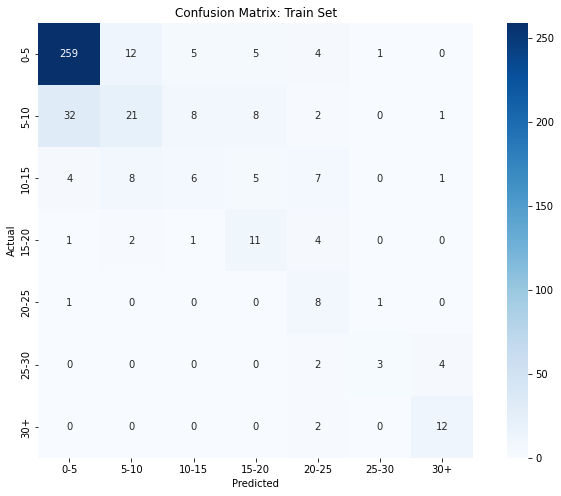

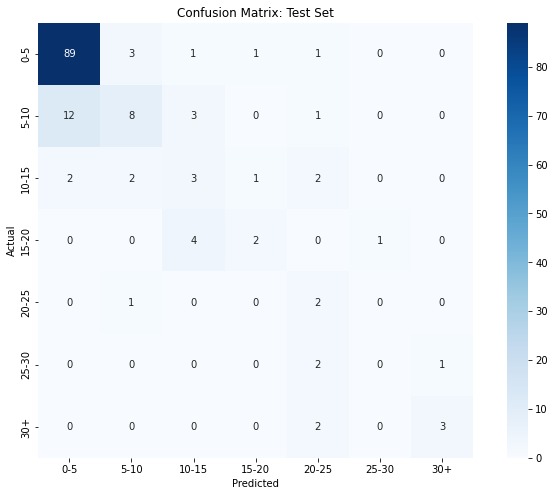

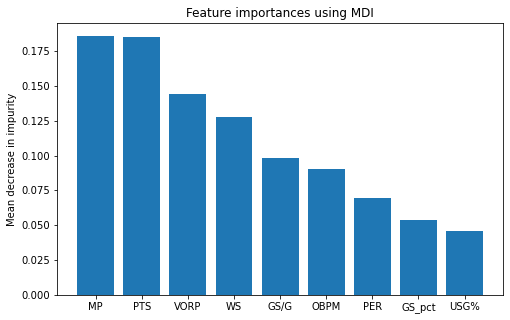

In [ ]:
feats = ['GS/G', 'GS_pct', 'MP', 'PTS', 'VORP', 'USG%','WS', 'OBPM','PER']

X_train, X_test, y_train, y_test = train_test_split(df_model[feats], df_model['Sal_class'], test_size = 0.25,
                                                     stratify=df_model['Sal_class'], random_state=42)

clf =  RandomForestClassifier(n_estimators = 3000, random_state=42, class_weight='balanced',
                              max_depth=2, max_features=2, criterion='gini',min_samples_leaf=10
                             )

clf_fit, X_train, X_test = scale_and_fit(X_train, X_test, y_train, y_test, feats, clf,scaling=False)

rf_feature_importances(feats, clf_fit)

# Final Model

* Retrain on full training set and validate on final test set

Train accuracy:   0.7193877551020408
Test accuracy:   0.6794871794871795 

Features ranked using MDI:
['MP', 'PTS', 'VORP', 'WS', 'GS/G', 'OBPM', 'GS_pct', 'USG%']


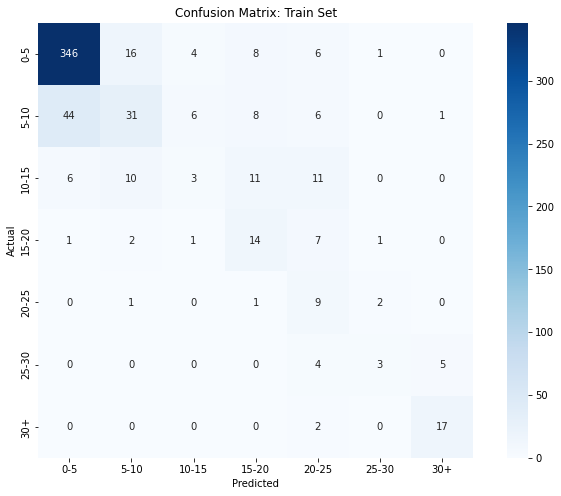

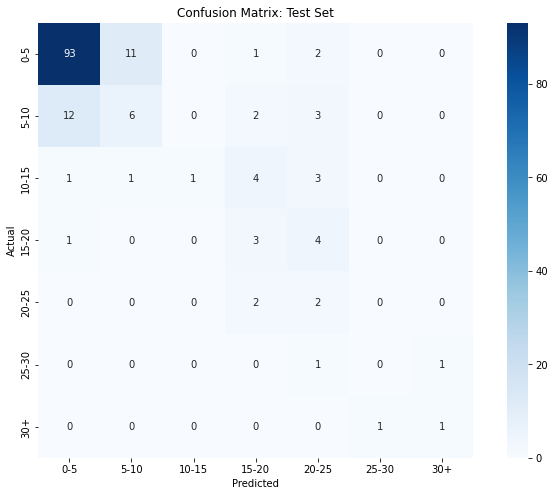

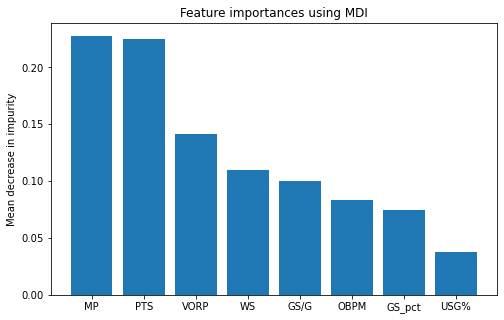

In [ ]:
feats = ['GS/G','GS_pct', 'MP', 'PTS', 'VORP', 'USG%','WS','OBPM']

X_train, X_test, y_train, y_test = (df_model[feats], df_holdout[feats], 
                                    df_model['Sal_class'], df_holdout['Sal_class'])

clf_final =  RandomForestClassifier(n_estimators = 6000, random_state=42, criterion='gini', 
                                    max_depth=2, max_features=2,  min_samples_leaf = 10,
                                    class_weight='balanced',
                                    )

clf_final_fit, X_train, X_test = scale_and_fit(X_train, X_test, y_train, y_test, feats, clf_final,scaling=False)

rf_feature_importances(feats, clf_final_fit)

## Save model and predictions

In [ ]:
# model_filename = 'RF_model.sav'
filename = r'/Users/richardsihombing/Documents/BigDataNBA/data/RF_model.sav'
pickle.dump(clf_final_fit,open(filename,'wb'))

predictions = clf_final_fit.predict(df[feats])
df['Sal_class_predict'] = predictions

predict_probas = clf_final_fit.predict_proba(df[feats]).tolist()
df['Sal_class_predict_proba'] = predict_probas

predictions2021 = clf_final_fit.predict(df2021[feats])
df2021['Sal_class_predict'] = predictions2021

predict_probas2021 = clf_final_fit.predict_proba(df2021[feats]).tolist()
df2021['Sal_class_predict_proba'] = predict_probas2021

df.to_csv(r'/Users/richardsihombing/Documents/BigDataNBA/data/model_pastyears.csv')
df2021.to_csv(r'/Users/richardsihombing/Documents/BigDataNBA/data/model_currentyear.csv')